Thanks to The AI Guy on Youtube for showing how to set up the YOLOv4 detector on Colab. Youtube Source: https://www.youtube.com/watch?v=mKAEGSxwOAY

Thanks to Mingxing Tan on Github for the Colab setup instructions for the EfficientDet detector. Github Source: https://github.com/google/automl/blob/master/efficientdet/tutorial.ipynb

Thanks to Tsung-Yi Lin on Github for the COCO evaluation demo.
Source: https://github.com/cocodataset/cocoapi/blob/master/PythonAPI/pycocoEvalDemo.ipynb

First, enable GPU hardware acceleration through the Runtime settings.

Installing the Darknet framework and the YOLO detector.

In [ ]:
# clone darknet repo
!git clone https://github.com/AlexeyAB/darknet

In [ ]:
# modify Makefile to enable OPENCV and CUDA
!sed -i 's/OPENCV=0/OPENCV=1/' darknet/Makefile
!sed -i 's/GPU=0/GPU=1/' darknet/Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' darknet/Makefile
!sed -i 's/CUDNN_HALF=0/CUDNN_HALF=1/' darknet/Makefile

In [ ]:
# verify CUDA is working
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243


In [ ]:
# build the darknet framework
%cd darknet
!make
%cd ..

In [ ]:
# download weights of various pre-trained models
%cd darknet
# YOLOv4
!wget https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v3_optimal/yolov4.weights
%cd ..


/content/darknet
--2020-12-18 22:04:06--  https://raw.githubusercontent.com/felixlephuoc/Annotating-Images-Object-Detection-API/master/sample_images/intersection.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 151973 (148K) [image/jpeg]
Saving to: ‘intersection.jpg’

intersection.jpg    100%[===================>] 148.41K  --.-KB/s    in 0.004s  

2020-12-18 22:04:06 (39.2 MB/s) - ‘intersection.jpg’ saved [151973/151973]

 CUDA-version: 10010 (10010), cuDNN: 7.6.5, CUDNN_HALF=1, GPU count: 1  
 CUDNN_HALF=1 
 OpenCV version: 3.2.0
 0 : compute_capability = 750, cudnn_half = 1, GPU: Tesla T4 
net.optimized_memory = 0 
mini_batch = 1, batch = 8, time_steps = 1, train = 0 
...
intersection.jpg: Predicted in 33.997000 milli-seconds.
car: 95%
traffic light: 38%
car

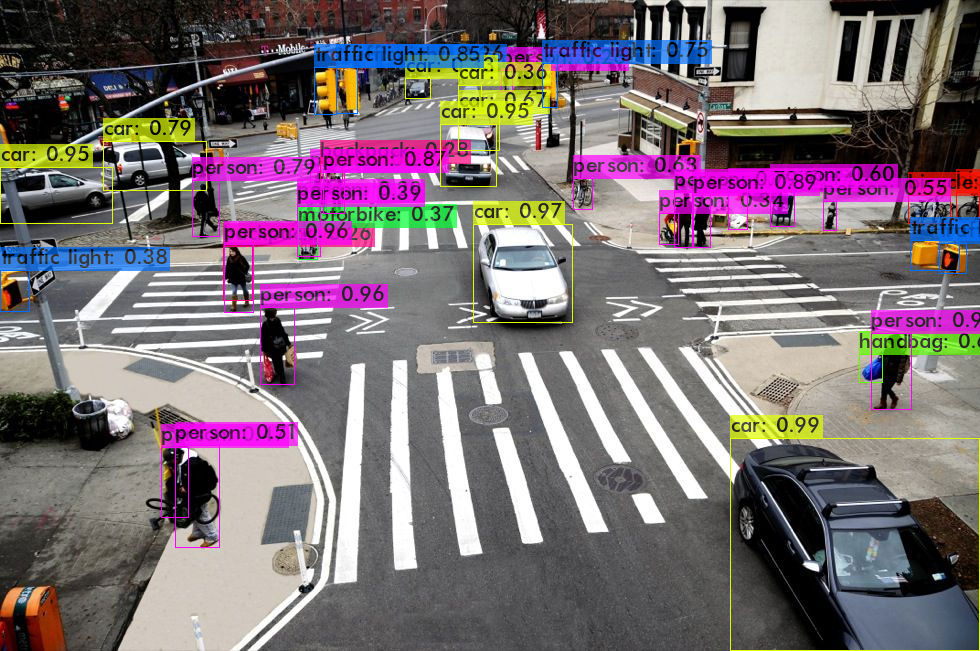

/


In [ ]:
# Sample prediction
%cd /content/darknet/
!wget https://raw.githubusercontent.com/felixlephuoc/Annotating-Images-Object-Detection-API/master/sample_images/intersection.jpg
!./darknet detector test cfg/coco.data cfg/yolov4.cfg yolov4.weights -thresh 0.25 -dont_show intersection.jpg

import cv2
from google.colab.patches import cv2_imshow
image = cv2.imread('predictions.jpg')
cv2_imshow(image)

%cd ../..

If you do not want to continue with the rest of the detector comparison, you can stop here as YOLOv4 is now set up.

In [ ]:
# YOLOv3
%cd darknet
!wget https://pjreddie.com/media/files/yolov3.weights
%cd ..

Installing the EfficientDet detector.

In [ ]:
# Python imports
import os
import sys
import tensorflow.compat.v1 as tf

In [ ]:
# clone repository and install requirements
!git clone --depth 1 https://github.com/google/automl
%cd automl/efficientdet
!pip install -r requirements.txt
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
%cd ../..

In [ ]:
# download various checkpointed models
!wget https://storage.googleapis.com/cloud-tpu-checkpoints/efficientdet/coco/efficientdet-d0.tar.gz
!tar zxf efficientdet-d0.tar.gz
!wget https://storage.googleapis.com/cloud-tpu-checkpoints/efficientdet/coco/efficientdet-d1.tar.gz
!tar zxf efficientdet-d1.tar.gz
!wget https://storage.googleapis.com/cloud-tpu-checkpoints/efficientdet/coco/efficientdet-d2.tar.gz
!tar zxf efficientdet-d2.tar.gz
!wget https://storage.googleapis.com/cloud-tpu-checkpoints/efficientdet/coco/efficientdet-d3.tar.gz
!tar zxf efficientdet-d3.tar.gz

Comparing model precision on the MS COCO 2017 validation set.

In [ ]:
# since the GPU used can change through sessions, we check which GPU we are using
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-09db8a5d-dab6-8dd7-7375-e4fb8ef8f4f4)


In [ ]:
# download MS COCO validation dataset
!wget http://images.cocodataset.org/zips/val2017.zip
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip
!unzip -q val2017.zip
!unzip annotations_trainval2017.zip

In [ ]:
# YOLO detector evaluation setup
%cd val2017
!printf '%s\n' "$PWD"/* > /content/val2017.txt
%cd ..

!sed -i 's#coco_testdev#/content/val2017.txt#' /content/darknet/cfg/coco.data
!sed -i 's#/home/pjreddie/backup/#backup#' /content/darknet/cfg/coco.data

/content/val2017
/content


In [ ]:
# Set YOLOv4 batch size to 1
!sed -i 's/batch=[0-9]*/batch=1/' /content/darknet/cfg/yolov4.cfg

In [ ]:
# EfficientDet evaluation setup
%cd /content/automl/efficientdet
!mkdir tfrecord
!PYTHONPATH=".:$PYTHONPATH"  python dataset/create_coco_tfrecord.py \
    --image_dir=/content/val2017 \
    --caption_annotations_file=/content/annotations/captions_val2017.json \
    --output_file_prefix=tfrecord/val \
    --num_shards=32
%cd ../..

In [ ]:
# validate YOLOv4 detector at 608 x 608
%cd /content/darknet
!sed -i 's/^width=[0-9]*/width=608/' cfg/yolov4.cfg
!sed -i 's/^height=[0-9]*/height=608/' cfg/yolov4.cfg
!./darknet detector valid cfg/coco.data cfg/yolov4.cfg yolov4.weights
!mv results/coco_results.json /content/detections_val2017_yolov4-608_results.json
%cd ..

In [ ]:
# validate YOLOv4 detector at 512 x 512
%cd /content/darknet
!sed -i 's/^width=[0-9]*/width=512/' cfg/yolov4.cfg
!sed -i 's/^height=[0-9]*/height=512/' cfg/yolov4.cfg
!./darknet detector valid cfg/coco.data cfg/yolov4.cfg yolov4.weights
!mv results/coco_results.json /content/detections_val2017_yolov4-512_results.json
%cd ..

In [ ]:
# validate YOLOv4 detector at 416 x 416
%cd /content/darknet
!sed -i 's/^width=[0-9]*/width=416/' cfg/yolov4.cfg
!sed -i 's/^height=[0-9]*/height=416/' cfg/yolov4.cfg
!./darknet detector valid cfg/coco.data cfg/yolov4.cfg yolov4.weights
!mv results/coco_results.json /content/detections_val2017_yolov4-416_results.json
%cd ..

In [ ]:
# validate YOLOv3 detector at 416 x 416
%cd /content/darknet
!sed -i 's/^width=[0-9]*/width=416/' cfg/yolov3.cfg
!sed -i 's/^height=[0-9]*/height=416/' cfg/yolov3.cfg
!./darknet detector valid cfg/coco.data cfg/yolov3.cfg yolov3.weights
!mv results/coco_results.json /content/detections_val2017_yolov3-416_results.json
%cd ..

In [ ]:
# validate YOLOv3 detector at 512 x 512
%cd /content/darknet
!sed -i 's/^width=[0-9]*/width=512/' cfg/yolov3.cfg
!sed -i 's/^height=[0-9]*/height=512/' cfg/yolov3.cfg
!./darknet detector valid cfg/coco.data cfg/yolov3.cfg yolov3.weights
!mv results/coco_results.json /content/detections_val2017_yolov3-512_results.json
%cd ..

In [ ]:
# validate YOLOv3 detector at 608 x 608
%cd /content/darknet
!sed -i 's/^width=[0-9]*/width=608/' cfg/yolov3.cfg
!sed -i 's/^height=[0-9]*/height=608/' cfg/yolov3.cfg
!./darknet detector valid cfg/coco.data cfg/yolov3.cfg yolov3.weights
!mv results/coco_results.json /content/detections_val2017_yolov3-608_results.json
%cd ..

In [ ]:
# download and build the coco evaluation code
!git clone https://github.com/cocodataset/cocoapi.git
%cd /content/cocoapi/PythonAPI
!make
%cd ../..

In [ ]:
# imports
%cd /content/cocoapi/PythonAPI
%matplotlib inline
import matplotlib.pyplot as plt
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
import numpy as np
import skimage.io as io
import pylab
pylab.rcParams['figure.figsize'] = (10.0, 8.0)

/content/cocoapi/PythonAPI


In [ ]:
annType = ['segm','bbox','keypoints']
annType = annType[1]      #specify type here
prefix = 'person_keypoints' if annType=='keypoints' else 'instances'
print('Running demo for *{}* results.'.format(annType))

Running demo for *bbox* results.


In [ ]:
#initialize COCO ground truth api
dataDir='../../'
dataType='val2017'
annFile = '%s/annotations/%s_%s.json'%(dataDir,prefix,dataType)
cocoGt=COCO(annFile)

loading annotations into memory...
Done (t=0.41s)
creating index...
index created!


In [ ]:
# evaluate YOLOv4 at 608 x 608
resFile='%s/detections_val2017_yolov4-608_results.json'
resFile = resFile%(dataDir)
cocoDt=cocoGt.loadRes(resFile)

imgIds=sorted(cocoGt.getImgIds())
imgIds=imgIds[0:100]
imgId = imgIds[np.random.randint(100)]

# running evaluation
cocoEval = COCOeval(cocoGt,cocoDt,annType)
cocoEval.params.imgIds  = imgIds
cocoEval.evaluate()
cocoEval.accumulate()
cocoEval.summarize()

Loading and preparing results...
DONE (t=7.14s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.75s).
Accumulating evaluation results...
DONE (t=0.53s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.620
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.847
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.684
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.422
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.661
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.770
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.470
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.692
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.719
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

In [ ]:
# evaluate YOLOv4 at 512 x 512
resFile='%s/detections_val2017_yolov4-512_results.json'
resFile = resFile%(dataDir)
cocoDt=cocoGt.loadRes(resFile)

imgIds=sorted(cocoGt.getImgIds())
imgIds=imgIds[0:100]
imgId = imgIds[np.random.randint(100)]

# running evaluation
cocoEval = COCOeval(cocoGt,cocoDt,annType)
cocoEval.params.imgIds  = imgIds
cocoEval.evaluate()
cocoEval.accumulate()
cocoEval.summarize()

Loading and preparing results...
DONE (t=6.08s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.73s).
Accumulating evaluation results...
DONE (t=0.52s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.589
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.814
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.661
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.390
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.647
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.749
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.462
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.672
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.694
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

In [ ]:
# evaluate YOLOv4 at 416 x 416
resFile='%s/detections_val2017_yolov4-416_results.json'
resFile = resFile%(dataDir)
cocoDt=cocoGt.loadRes(resFile)

imgIds=sorted(cocoGt.getImgIds())
imgIds=imgIds[0:100]
imgId = imgIds[np.random.randint(100)]

# running evaluation
cocoEval = COCOeval(cocoGt,cocoDt,annType)
cocoEval.params.imgIds  = imgIds
cocoEval.evaluate()
cocoEval.accumulate()
cocoEval.summarize()

Loading and preparing results...
DONE (t=7.27s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.80s).
Accumulating evaluation results...
DONE (t=0.53s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.583
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.793
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.662
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.345
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.641
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.778
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.445
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.664
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.684
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

In [ ]:
# evaluate YOLOv3 at 608 x 608
resFile='%s/detections_val2017_yolov3-608_results.json'
resFile = resFile%(dataDir)
cocoDt=cocoGt.loadRes(resFile)

imgIds=sorted(cocoGt.getImgIds())
imgIds=imgIds[0:100]
imgId = imgIds[np.random.randint(100)]

# running evaluation
cocoEval = COCOeval(cocoGt,cocoDt,annType)
cocoEval.params.imgIds  = imgIds
cocoEval.evaluate()
cocoEval.accumulate()
cocoEval.summarize()

Loading and preparing results...
DONE (t=5.12s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.61s).
Accumulating evaluation results...
DONE (t=0.52s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.489
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.798
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.506
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.346
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.557
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.593
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.389
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.597
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.617
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

In [ ]:
# evaluate YOLOv3 at 512 x 512
resFile='%s/detections_val2017_yolov3-512_results.json'
resFile = resFile%(dataDir)
cocoDt=cocoGt.loadRes(resFile)

imgIds=sorted(cocoGt.getImgIds())
imgIds=imgIds[0:100]
imgId = imgIds[np.random.randint(100)]

# running evaluation
cocoEval = COCOeval(cocoGt,cocoDt,annType)
cocoEval.params.imgIds  = imgIds
cocoEval.evaluate()
cocoEval.accumulate()
cocoEval.summarize()

Loading and preparing results...
DONE (t=5.21s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.49s).
Accumulating evaluation results...
DONE (t=0.50s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.506
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.792
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.545
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.330
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.545
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.658
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.411
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.592
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.612
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

In [ ]:
# evaluate YOLOv3 at 416 x 416
resFile='%s/detections_val2017_yolov3-416_results.json'
resFile = resFile%(dataDir)
cocoDt=cocoGt.loadRes(resFile)

imgIds=sorted(cocoGt.getImgIds())
imgIds=imgIds[0:100]
imgId = imgIds[np.random.randint(100)]

# running evaluation
cocoEval = COCOeval(cocoGt,cocoDt,annType)
cocoEval.params.imgIds  = imgIds
cocoEval.evaluate()
cocoEval.accumulate()
cocoEval.summarize()

Loading and preparing results...
DONE (t=7.32s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.56s).
Accumulating evaluation results...
DONE (t=0.49s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.493
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.787
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.515
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.318
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.526
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.671
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.393
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.581
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.601
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

In [ ]:
# evaluate EfficientDet-D0
%cd /content/automl/efficientdet/
MODEL = 'efficientdet-d0'
ckpt_path = '/content/{}'.format(MODEL)
!python main.py --mode=eval  \
    --model_name={MODEL}  --model_dir={ckpt_path}  \
    --validation_file_pattern=tfrecord/val*  \
    --val_json_file=/content/annotations/instances_val2017.json

/content/automl/efficientdet
...
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.335
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.515
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.358
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.125
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.386
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.526
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.288
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.451
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.475
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.200
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.557
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.699
INFO:te

In [ ]:
# evaluate EfficientDet-D1
%cd /content/automl/efficientdet/
MODEL = 'efficientdet-d1'
ckpt_path = '/content/{}'.format(MODEL)
!python main.py --mode=eval  \
    --model_name={MODEL}  --model_dir={ckpt_path}  \
    --validation_file_pattern=tfrecord/val*  \
    --val_json_file=/content/annotations/instances_val2017.json

/content/automl/efficientdet
...
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.392
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.579
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.423
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.186
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.446
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.570
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.322
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.510
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.541
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.302
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.607
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.746
INFO:te

In [ ]:
# evaluate EfficientDet-D2
%cd /content/automl/efficientdet/
MODEL = 'efficientdet-d2'
ckpt_path = '/content/{}'.format(MODEL)
!python main.py --mode=eval  \
    --model_name={MODEL}  --model_dir={ckpt_path}  \
    --validation_file_pattern=tfrecord/val*  \
    --val_json_file=/content/annotations/instances_val2017.json

/content/automl/efficientdet
...
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.426
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.615
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.458
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.246
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.480
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.593
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.342
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.548
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.579
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.363
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.644
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.763
INFO:te

In [ ]:
# evaluate EfficientDet-D3
%cd /content/automl/efficientdet/
MODEL = 'efficientdet-d3'
ckpt_path = '/content/{}'.format(MODEL)
!python main.py --mode=eval  \
    --model_name={MODEL}  --model_dir={ckpt_path}  \
    --validation_file_pattern=tfrecord/val*  \
    --val_json_file=/content/annotations/instances_val2017.json

/content/automl/efficientdet
...
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.459
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.647
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.497
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.282
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.502
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.617
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.359
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.578
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.614
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.412
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.666
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.780
INFO:te

Benchmarking model computational performance.

In [ ]:
# download benchmark video for the YOLO detectors
%cd /content/darknet
!wget https://data.kitware.com/api/v1/item/56f5825c8d777f753209ca47/download -O test.mp4
%cd ..

In [ ]:
# benchmark YOLOv4 at 608 x 608
# manually stop the benchmark when AVG_FPS does not widely fluctuate
%cd /content/darknet
!sed -i 's/^width=[0-9]*/width=608/' cfg/yolov4.cfg
!sed -i 's/^height=[0-9]*/height=608/' cfg/yolov4.cfg
!./darknet detector demo cfg/coco.data cfg/yolov4.cfg yolov4.weights test.mp4 -benchmark
%cd ..

FPS:28.5 	 AVG_FPS:28.1
Objects:


...


FPS:28.8 	 AVG_FPS:28.7
Objects:


FPS:28.7 	 AVG_FPS:28.7
^C
/content


In [ ]:
# benchmark YOLOv4 at 512 x 512
# manually stop the benchmark when AVG_FPS does not widely fluctuate
%cd /content/darknet
!sed -i 's/^width=[0-9]*/width=512/' cfg/yolov4.cfg
!sed -i 's/^height=[0-9]*/height=512/' cfg/yolov4.cfg
!./darknet detector demo cfg/coco.data cfg/yolov4.cfg yolov4.weights test.mp4 -benchmark
%cd ..

FPS:39.5 	 AVG_FPS:39.4
Objects:


...


FPS:40.4 	 AVG_FPS:39.8
^C
/content


In [ ]:
# benchmark YOLOv4 at 416 x 416
# manually stop the benchmark when AVG_FPS does not widely fluctuate
%cd /content/darknet
!sed -i 's/^width=[0-9]*/width=416/' cfg/yolov4.cfg
!sed -i 's/^height=[0-9]*/height=416/' cfg/yolov4.cfg
!./darknet detector demo cfg/coco.data cfg/yolov4.cfg yolov4.weights test.mp4 -benchmark
%cd ..

FPS:51.4 	 AVG_FPS:50.6
Objects:


...


FPS:51.6 	 AVG_FPS:50.6
^C
/content


In [ ]:
# benchmark YOLOv3 at 608 x 608
# manually stop the benchmark when AVG_FPS does not widely fluctuate
%cd /content/darknet
!sed -i 's/^width=[0-9]*/width=608/' cfg/yolov3.cfg
!sed -i 's/^height=[0-9]*/height=608/' cfg/yolov3.cfg
!./darknet detector demo cfg/coco.data cfg/yolov3.cfg yolov3.weights test.mp4 -benchmark
%cd ..

FPS:0.0 	 AVG_FPS:0.0
Objects:


...


FPS:34.1 	 AVG_FPS:33.7
^C
/content


In [ ]:
# benchmark YOLOv3 at 512 x 512
# manually stop the benchmark when AVG_FPS does not widely fluctuate
%cd /content/darknet
!sed -i 's/^width=[0-9]*/width=512/' cfg/yolov3.cfg
!sed -i 's/^height=[0-9]*/height=512/' cfg/yolov3.cfg
!./darknet detector demo cfg/coco.data cfg/yolov3.cfg yolov3.weights test.mp4 -benchmark
%cd ..

FPS:0.0 	 AVG_FPS:0.0
Objects:


...


FPS:47.8 	 AVG_FPS:47.2
^C
/content


In [ ]:
# benchmark YOLOv3 at 416 x 416
# manually stop the benchmark when AVG_FPS does not widely fluctuate
%cd /content/darknet
!sed -i 's/^width=[0-9]*/width=416/' cfg/yolov3.cfg
!sed -i 's/^height=[0-9]*/height=416/' cfg/yolov3.cfg
!./darknet detector demo cfg/coco.data cfg/yolov3.cfg yolov3.weights test.mp4 -benchmark
%cd ..

FPS:61.9 	 AVG_FPS:61.0
Objects:


...


FPS:62.3 	 AVG_FPS:61.0
^C
/content


In [ ]:
# benchmark EfficientDet-D0
%cd /content/automl/efficientdet/
m = 'efficientdet-d0'
batch_size = 1
m_path = '/content/efficientdet-d0/'

saved_model_dir = 'savedmodel0'
!rm -rf {saved_model_dir}
!python model_inspect.py --runmode=saved_model --model_name={m} \
  --ckpt_path={m_path} --saved_model_dir={saved_model_dir} \
  --batch_size={batch_size}  --hparams="mixed_precision=true"
!python model_inspect.py --runmode=saved_model_benchmark --model_name={m} \
  --ckpt_path={m_path} --saved_model_dir={saved_model_dir}/{m}_frozen.pb \
  --batch_size={batch_size}  --hparams="mixed_precision=true" --input_image=testdata/img1.jpg
%cd /content/

/content/automl/efficientdet
...
Per batch inference time:  0.019315457199991216
FPS:  51.772007757624024
/content


In [ ]:
# benchmark EfficientDet-D1
%cd /content/automl/efficientdet/
m = 'efficientdet-d1'
batch_size = 1
m_path = '/content/efficientdet-d1/'

saved_model_dir = 'savedmodel1'
!rm -rf {saved_model_dir}
!python model_inspect.py --runmode=saved_model --model_name={m} \
  --ckpt_path={m_path} --saved_model_dir={saved_model_dir} \
  --batch_size={batch_size}  --hparams="mixed_precision=true"
!python model_inspect.py --runmode=saved_model_benchmark --model_name={m} \
  --ckpt_path={m_path} --saved_model_dir={saved_model_dir}/{m}_frozen.pb \
  --batch_size={batch_size}  --hparams="mixed_precision=true" --input_image=testdata/img1.jpg
%cd /content/

/content/automl/efficientdet
...
Per batch inference time:  0.029237009800090162
FPS:  34.203224161347585
/content


In [ ]:
# benchmark EfficientDet-D2
%cd /content/automl/efficientdet/
m = 'efficientdet-d2'
batch_size = 1
m_path = '/content/efficientdet-d2/'

saved_model_dir = 'savedmodel2'
!rm -rf {saved_model_dir}
!python model_inspect.py --runmode=saved_model --model_name={m} \
  --ckpt_path={m_path} --saved_model_dir={saved_model_dir} \
  --batch_size={batch_size}  --hparams="mixed_precision=true"
!python model_inspect.py --runmode=saved_model_benchmark --model_name={m} \
  --ckpt_path={m_path} --saved_model_dir={saved_model_dir}/{m}_frozen.pb \
  --batch_size={batch_size}  --hparams="mixed_precision=true" --input_image=testdata/img1.jpg
%cd /content/

/content/automl/efficientdet
...
Per batch inference time:  0.03532559300001594
FPS:  28.308088133143265
/content


In [ ]:
# benchmark EfficientDet-D3
%cd /content/automl/efficientdet/
m = 'efficientdet-d3'
batch_size = 1
m_path = '/content/efficientdet-d3/'

saved_model_dir = 'savedmodel3'
!rm -rf {saved_model_dir}
!python model_inspect.py --runmode=saved_model --model_name={m} \
  --ckpt_path={m_path} --saved_model_dir={saved_model_dir} \
  --batch_size={batch_size}  --hparams="mixed_precision=true"
!python model_inspect.py --runmode=saved_model_benchmark --model_name={m} \
  --ckpt_path={m_path} --saved_model_dir={saved_model_dir}/{m}_frozen.pb \
  --batch_size={batch_size}  --hparams="mixed_precision=true" --input_image=testdata/img1.jpg
%cd /content/

/content/automl/efficientdet
...
Per batch inference time:  0.0555581741999049
FPS:  17.999151599220692
/content


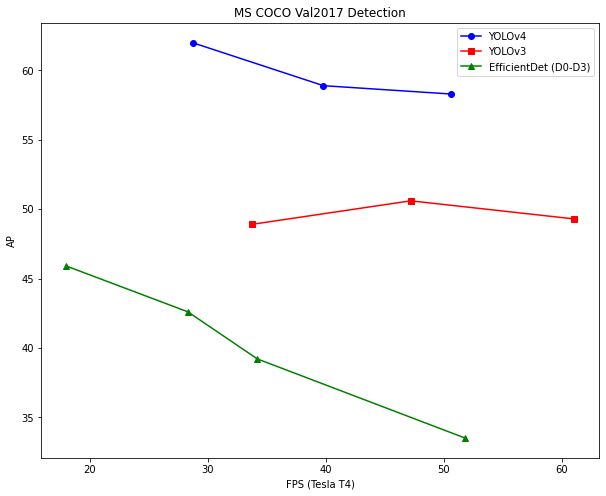

In [ ]:
# visualize the results
import matplotlib.pyplot as plt
plt.plot([50.6, 39.8, 28.7], [58.3, 58.9, 62.0], '-bo', label='YOLOv4')
plt.plot([61, 47.2, 33.7], [49.3, 50.6, 48.9], '-rs', label='YOLOv3')
plt.plot([51.8, 34.2, 28.3, 18], [33.5, 39.2, 42.6, 45.9], '-g^', label='EfficientDet (D0-D3)')
plt.title('MS COCO Val2017 Detection')
plt.xlabel('FPS (Tesla T4)')
plt.ylabel('AP')
plt.legend()
plt.show()